In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import StrMethodFormatter

In [2]:
def get_metric_file(ckpt_folder, metric):
    
    if metric == 'test_acc':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'loss_acc_test.pkl')
    elif metric == 'loss':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'loss_acc.pkl')
    elif metric == 'CKA':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'CKA_mixup_alpha_16.0.pkl')
    elif 'hessian' in metric:
        file_name = os.path.join(ckpt_folder, 'metrics/', 'hessian.pkl')
    elif metric == 'mode_connectivity':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'curve_test.npz')
    elif metric == 'L2':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'model_dist.pkl')
    
    assert os.path.exists(file_name)
    return file_name

In [3]:
def get_metric_val(metric_file, metric):
    
    if metric == 'test_acc':
        results = pickle.load(open(metric_file, 'rb'))
        return np.mean([results[n]['accuracy'] for n in range(5)])
    if metric == 'loss':
        results = pickle.load(open(metric_file, 'rb'))
        return np.mean([results[n]['loss'] for n in range(5)])
    elif metric == 'CKA':
        results = pickle.load(open(metric_file, "rb"))
        CKA_all = []
        for exp_ind1 in range(5):
            for exp_ind2 in range(5):
                if exp_ind1 != exp_ind2:
                    CKA_all.append(results['representation_similarity'][exp_ind1][exp_ind2][-1])
        return np.mean(CKA_all)
    elif 'hessian' in metric:
        results = pickle.load(open(metric_file, "rb"))
        if '_e' in metric:
            return np.log(np.mean([results[n]['top_eigenvalue'][0] for n in range(5)]))
        elif '_t' in metric:
            return np.log(np.mean([results[n]['trace'] for n in range(5)]))
    elif metric == 'mode_connectivity':
        result = np.load(metric_file)['tr_err']
        u = np.argmax(np.abs(result - (result[0] + result[4])/2))
        return (result[0] + result[4])/2 - result[u]
    elif metric == 'L2':
        results = pickle.load(open(metric_file, "rb"))
        dist_all = []
        for exp_ind1 in range(5):
            for exp_ind2 in range(5):
                if exp_ind1 != exp_ind2:
                    dist_all.append(results['model_distance'][exp_ind1][exp_ind2]['dist'])
        return np.mean(dist_all)

In [4]:
def vminmax(metric):
    if metric == 'test_acc':
        vmin, vmax = 56, 91
    elif metric == 'loss':
        vmin, vmax = 0, 3
    elif metric == 'CKA':
        vmin, vmax = 0.3, 0.8
    elif metric == 'mode_connectivity':
        vmin, vmax = -30, 30
    elif metric == 'L2':
        vmin, vmax = 0, 100
    elif metric == 'hessian_e':
        vmin, vmax = 0, 6
    elif metric == 'hessian_t':
        vmin, vmax = 3, 8
        
    return vmin, vmax

In [5]:
def plot_2Dphase(phase2D, x_label_list, y_label_list, metric, metric_title):
    
    fig, ax = plt.subplots(1,1, figsize = (5,4))
    
    X,Y = np.meshgrid(x_label_list, y_label_list)
    vmin, vmax = vminmax(metric)
    
    if metric == 'mode_connectivity':
        pos = ax.pcolormesh(X,Y,phase2D, vmin=vmin, vmax=vmax, cmap="seismic")
    elif metric in ['L2', 'loss', 'hessian_e', 'hessian_t']:
        pos = ax.pcolormesh(X,Y,phase2D, vmin=vmin, vmax=vmax, cmap="viridis_r")
    else:
        pos = ax.pcolormesh(X,Y,phase2D, vmin=vmin, vmax=vmax, cmap="viridis")
    
    ax.set_xscale("log")
                
    ax.set_yticks(y_label_list)
    ax.set_yscale("log")
    ax.invert_yaxis()
    
    ax.set_xlabel('Width of model', fontsize=20)
    ax.set_ylabel(f'T (Batch size)', fontsize=20)
    ax.set_title(metric_title, fontsize=20)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(pos, cax=cax)
    cbar.ax.tick_params(labelsize=18)
    plt.savefig(f'{metric}.png')

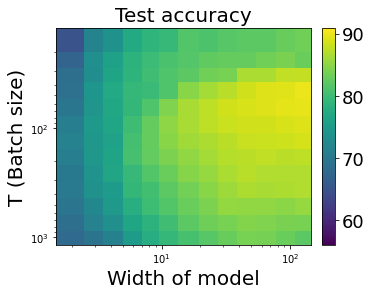

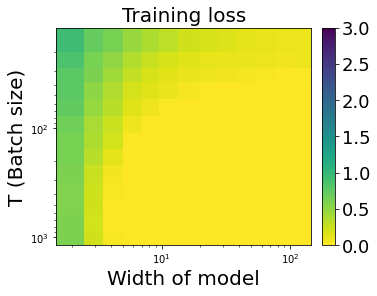

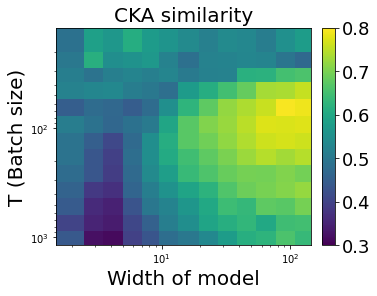

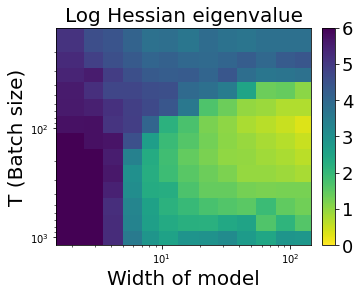

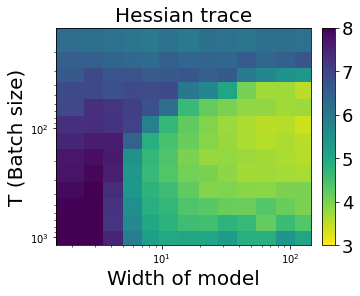

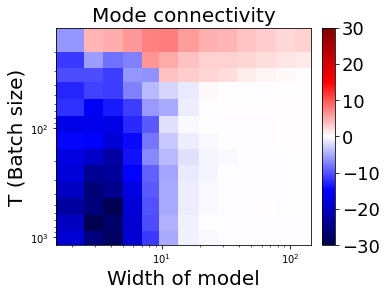

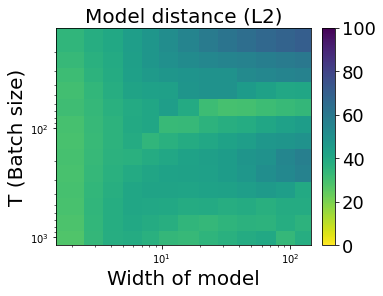

In [6]:
width_list = [2, 3, 4, 6, 8, 11, 16, 23, 32, 45, 64, 91, 128]
bs_list = [16, 24, 32, 44, 64, 92, 128, 180, 256, 364, 512, 724, 1024]
metric_list = ['test_acc', 'loss', 'CKA', 'hessian_e', 'hessian_t', 'mode_connectivity', 'L2']
metric_title_list = ['Test accuracy', 'Training loss', 'CKA similarity', 'Log Hessian eigenvalue', 'Hessian trace', 'Mode connectivity', 'Model distance (L2)']

for metric, metric_title in zip(metric_list, metric_title_list):

    lenx = len(width_list)
    leny = len(bs_list)
    phase2D = np.zeros((leny, lenx))

    for j,width in enumerate(width_list):
        for i,bs in enumerate(bs_list):
            ckpt_folder = f'../../checkpoint/different_knobs_subset_10/bs_{bs}/lr_decay/ResNet18_w{width}/'
            metric_file = get_metric_file(ckpt_folder, metric)
            phase2D[i][j] = get_metric_val(metric_file, metric)
            
    plot_2Dphase(phase2D, width_list, bs_list, metric, metric_title)
    